# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [84]:
# Astonishingly there seems to be no clean way to set up the Python path automatically for a script that does not
# reside in the root folder. This will need to be added to all notebooks unless a better solution comes along.
import os, sys
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from collections import namedtuple
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import scipy

from utils import load_yaml

sns.set_theme()

# Utility Functions

## Data Loading Functions

In [86]:
from tqdm import tqdm


def load_dataframes(eval_folder, verbose=False):
    """
    Given a folder with a number of pickled dataframes, load and return all of them.
    """
    if verbose:
        print(f"Loading from: {eval_folder.name}")
    all_frames = [pd.read_pickle(f) for f in eval_folder.glob("*.pkl")]
    if verbose:
        print(f"Loaded {len(all_frames)} dataframes for {eval_folder.name}.")
    return all_frames


def load_eval_data(eval_folder, verbose=False):
    """
    Given a folder with a number of pickled dataframes, load all results into a single dataframe.
    """
    all_frames = load_dataframes(eval_folder)  # Don't need the verbose flag here b/c the same info is printed below.
    if all_frames:
        all_data = pd.concat(all_frames)
    else:
        all_data = pd.DataFrame()
    if verbose:
        name = eval_folder.parent.name + "/" + eval_folder.name
        print(f"{name}: Loaded {len(all_frames)} dataframes for total size = {all_data.shape}")
    return all_data


def get_dataset_name(cfg):
    """
    Get the corrected name of the dataset specified in the given config.
    """
    if cfg["dataset"] == "omniimage":
        # Update OmniImage dataset name to disambiguate between different parameterizations.
        return "omniimage" + str(cfg["imgs_per_class"])
    return cfg["dataset"]


PreTrainData = namedtuple("PreTrainData", ["src_name", "target_name", "dflt"])
PRETRAIN_METADATA = [
    PreTrainData("model_name", "model_name", "n/a"),
    PreTrainData("train_method", "train_method", "n/a"),
    PreTrainData("lobotomize", "lobotomize", False),
    PreTrainData("lr", "train_lr", 0.0),  # Avoid name collision with transfer learning rate.
    PreTrainData("inner_lr", "inner_lr", 0.0),
    PreTrainData("outer_lr", "outer_lr", 0.0),
    PreTrainData("seed", "seed", 0),
]


def load_eval_data_with_model_info(model_name, eval_folder, train_configs, add_pretrain_info=True, verbose=False):
    """
    Load dataframes in the given folder, and edit the associated metadata.
    """
    all_data = load_eval_data(eval_folder, verbose)
    
    # Get the eval and train configs. NOTE: Assumes one config per folder.
    eval_cfg = load_yaml(next(iter(eval_folder.glob("eval-config-*.yml"))))
    train_cfg = train_configs[eval_folder.parent.stem]

    # Rename some columns and add some extra metadata.
    if len(all_data) > 0:
        # Replace model path with model shortname.
        # TODO: Need to find a more efficient way to do this.
        # Here's the original way to do it, and it's way too slow.
        #orig = all_data.index.get_level_values("model")[0]  # Get original name.
        #all_data.rename(index={orig: model_name}, level="model", inplace=True)  # Replace with short name.
        newdex = all_data.index.to_frame(index=False)
        newdex["model"] = model_name  # Replace entire model column w/ short name.
        
        # Set dataset names for train and test.
        # TODO: This should be done in the eval script itself.
        newdex.drop("dataset", axis=1, inplace=True)
        newdex.insert(1, "eval_dataset", get_dataset_name(eval_cfg))
        newdex.insert(1, "train_dataset", get_dataset_name(train_cfg))

        # Add info from a few select columns so we can use it for filtering/grouping.
        if add_pretrain_info:
            # We would allow them to be null if missing, except NaNs will mess up our groupbys due to a known bug
            # in Pandas: https://github.com/pandas-dev/pandas/issues/36470
            # Thus, we must supply non-null defaults.
            for k, target, dflt in PRETRAIN_METADATA:
                # Unfortunately our default for lobo is context-dependent. :-(
                if k == "lobotomize":
                    dflt = (train_cfg.get("train_method") != "iid")
                newdex[target] = train_cfg.get(k, dflt)

        newdex = pd.MultiIndex.from_frame(newdex, names=newdex.columns)
        all_data.set_index(newdex, inplace=True)

    return all_data


## Summarization Functions

Functions for processing dataframes to find the best performance within certain groupings.

In [317]:
from functools import partial


def combine_train_test_columns(df):
    # Combine train/test columns into a single column, for the convenience of using `sns.relplot()`.
    df = df.rename(columns={"train_acc": "train", "test_acc": "test"})
    df = df.melt(var_name="split", value_name="accuracy", ignore_index=False)
    df.set_index("split", append=True, inplace=True)
    return df


def get_index_columns(df, include=None, exclude=None):
    if not include:
        include = df.index.names
    if not exclude:
        exclude = []
    return list(filter(lambda x: x in include and x not in exclude, df.index.names))


def get_all_model_descriptor_columns(df, exclude=None):
    """
    Get a list of columns from the given dataframe which describe how a model was pre-trained.
    """
    model_cols = ["train_dataset"] + [md.target_name for md in PRETRAIN_METADATA]
    return get_index_columns(df, include=model_cols, exclude=exclude)


def get_unique_model_descriptor_columns(df):
    """
    Get a list of columns from the given dataframe which can be used to uniquely identify a model type, if we ignore
    random seed ("seed") and W&B run name ("model").
    """
    return get_all_model_descriptor_columns(df, exclude=["seed"])


def get_model_descriptions(df):
    """
    Get a dataframe with one row per unique model, and columns to describe the settings used to train that model.
    """
    model_cols = get_all_model_descriptor_columns(df)
    return df.groupby("model").apply(lambda group: group.index.to_frame().iloc[0][model_cols])


def ensure_unique(df, index_columns):
    """
    Ensures that the given columns only contain one value; otherwise raises an exception.

    This is a safety check to ensure we don't erroneously aggregate across runs that aren't comparable. For example,
    if our dataframe could have results from more than one model, we don't usually want to aggregate over all models,
    so we would pass in the "model" column here.
    """
    if isinstance(index_columns, str):
        index_columns = [index_columns]
    for col in index_columns:
        unique = df.index.get_level_values(col).unique()
        if len(unique) > 1:
            raise RuntimeError(f"Refusing to aggregate across runs with different '{col}': {unique.to_numpy()}.")


def filter_by_choices(df, index_col, desired_values):
    """
    Filter the given dataframe to only contain the rows where `index_col` takes one of the `desired_values`.
    """
    values = df.index.get_level_values(index_col)
    selected_rows = (values == desired_values[0])
    for v in desired_values[1:]:
        selected_rows |= (values == v)
    return df.loc[selected_rows]


def filter_by_value(df, index_col, desired_value):
    """
    Filter the given dataframe to only contain the rows where `index_col` takes the `desired_value`.
    """
    return filter_by_choices(df, index_col, [desired_value])


def filter_by_model(df, desired_models):
    """
    Filter the given dataframe to only contain the models from the given list.
    """
    return filter_by_choices(df, "model", desired_models)


def filter_to_match_models(df1, df2):
    """
    Filter `df1` to only contain the models found in `df2`.
    """
    return filter_by_model(df1, df2.index.get_level_values("model").unique())


def rename_like_models(df):
    """
    Sets the "model" column so that all models which share the same training settings, but differ only in random seed,
    will then share the same name. Each group will take the alphabetically first name.

    Args:
        df: The dataframe containing pre-trained model info.

    Returns:
        The same dataframe but with modified "model" values.
    """
    model_cols = get_unique_model_descriptor_columns(df)
    
    # We group by just the model descriptors. We keep each group the same, but we reassign the model name to be all
    # the same.
    def rename_group(group):
        # Choose a single name to represent the whole group.
        new_model_name = group.index.get_level_values("model").min()
        # Drop the existing "model" column from the index, and rebuild the index using a new model name.
        index_cols = get_index_columns(group, exclude=model_cols)
        newgroup = group.reset_index()
        # Drop all columns which will already be in the output.
        newgroup.drop(model_cols, axis=1, inplace=True)
        newgroup["model"] = new_model_name
        newgroup.set_index(index_cols, inplace=True)
        return newgroup
        
    df = df.groupby(model_cols, dropna=False).apply(rename_group)
    # Reset index to put model in the front.
    index_cols = get_index_columns(df, exclude=["model"])
    df.reset_index(inplace=True)
    df.set_index(["model"] + index_cols, inplace=True)
    
    # An alternative method is below. This is more concise, but unfortunately isn't sufficient, b/c some models are
    # missing from some categories. You need to take the min model name over *all*, not just per subgroup.
    # df = df.reset_index(level="model")
    # df = df.groupby(model_cols, dropna=False).agg({"model": "min", "accuracy": "mean"})
    # # Need to reset the whole index to get "model" back into the first slot.
    # df.reset_index(inplace=True)
    # df.set_index(["model"] + index_cols, inplace=True)

    return df


def select_best_lr(groupby_labels, train_group):
    """
    Reduces a dataframe with many learning rates to one with one learning rate, retaining all trials for the selected
    learning rate. Learning rate is selected by highest mean test accuracy.
    """
    test_perf = train_group.loc[train_group.index.get_level_values("split") == "test"]
    perf_per_lr = test_perf.groupby("lr").mean()
    # Tells us which LR is the best.
    best_lr = perf_per_lr.iloc[perf_per_lr.squeeze().argmax()].name
    # Grabs all trials corresponding to the best LR.
    best_lr_rows = train_group.index.get_level_values("lr") == best_lr
    # We must remove all the columns that are already specified by the group, because otherwise .apply() is not smart
    # enough to remove them and they will be duplicated.
    return train_group.loc[best_lr_rows].reset_index(level=groupby_labels, drop=True)


def select_best_lr_per_group(df):
    """
    Filters the given dataframe so it contains just the results of the best-performing learning rate at each point in
    time, for each different model / fine-tuning process. Note: this means different learning rates can be selected for
    different points _within the same training run_. Performance is measured as the average test accuracy over all
    trials (mean over the "trial" column).
    """
    # Shortcut: If LR is not applicable here, just return the original data.
    if "lr" not in df.index.names:
        return df.copy()
    
    # Group the potential data for each data point separately. So each group contains all trials and all learning rates
    # for a single test method (so all index columns except for those).
    groupby_labels = get_index_columns(df, exclude=["lr", "trial", "split"])
    eval_groups = df.groupby(groupby_labels, dropna=False)

    # For each point on the x-axis, select the learning rate with the best average performance over trials.
    # Need to use .apply() here because our function needs all columns at once.
    return eval_groups.apply(partial(select_best_lr, groupby_labels))


def get_final_perf_per_model(df, num_train_examples=None, split="test", print_result=False):
    """
    Gets and (optionally) prints the mean final test accuracy of each model in the given dataframe.
    """
    models = df.index.get_level_values("model")
    test_rows = (df.index.get_level_values("split") == split)
    if num_train_examples is not None:
        train_example_rows = df.index.get_level_values("train_examples") == num_train_examples
    else:
        train_example_rows = None
    # Different evaluation methods have slightly different naming schemes, unfortunately. Support all of them.
    if "classes_trained" in df.index.names:
        classes_trained = df.index.get_level_values("classes_trained")
        final_perf_rows = (classes_trained == classes_trained.max())
    elif "step" in df.index.names:
        step = df.index.get_level_values("step")
        final_perf_rows = (step == step.max())
    else:
        final_perf_rows = None

    if print_result:
        total_classes = df.index.get_level_values("classes").unique()
        if len(total_classes) > 1:
            print(f"WARNING: Aggregating over multiple class values:\n{total_classes}")
            cls_msg = ""
        else:
            cls_msg = f" on {total_classes.item()} classes"
        print(f"Final accuracy{cls_msg}:")

    final_perf_per_model = {}
    for m in models.unique():
        rows = (models == m) & test_rows
        if train_example_rows is not None:
            rows &= train_example_rows
        if final_perf_rows is not None:
            rows &= final_perf_rows
        final_acc = df.loc[rows, "accuracy"]
        stats = pd.DataFrame.from_records([{"model": m, "mean": final_acc.mean(), "std": final_acc.std()}],
                                          index="model")
        final_perf_per_model[m] = stats
        if print_result:
            print(f"{m: >30} | {stats['mean'].item():>5.1%} (std: {stats['std'].item():.1%})")

    return final_perf_per_model


def get_top_model_per_group(df, performance_per_model, group_cols=None):
    """
    Groups by the given columns and returns one model per group, where each model is the one with the highest average
    performance within that group, according to `performance_per_model`.

    Args:
        df: The dataframe containing pre-trained model info.
        performance_per_model: A dict with model names as keys and performance stats as values (higher is better).
        group_cols: A list of columns used to define the groups. Defaults to ["train_method", "lobotomize"] if not
                    supplied.

    Returns:
        A dataframe with one row per group, indexed by group columns and with a single column with the model names.
    """
    if not group_cols:
        group_cols = ["train_method", "lobotomize"]

    def select_best_model(train_group):
        models = train_group.index.get_level_values("model").unique()
        # Sort by mean and return the highest (last) one.
        return sorted([performance_per_model[m] for m in models], key=lambda e: e["mean"].item())[-1]

    # Now select the best model within each group.
    pretrain_groups = df.groupby(group_cols, dropna=False)
    return pretrain_groups.apply(select_best_model)


## Plotting Functions

In [109]:
import warnings


def add_category_column(df, group_cols=None):
    """
    Add a column to the given dataframe which summarizes the category groups in a string. Used to make an improved
    legend in plots. If `groupcols` is not provided, it defaults to ["train_method", "lobotomize"].
    """
    if not group_cols:
        group_cols = ["train_method", "lobotomize"]
    group_pos = [df.index.names.index(c) for c in group_cols]
    name_mapping = {
        "lobotomize": "lobo",
        "train_method": "method",
        "sequential_episodic": "seqep",
    }

    def map_name(name):
        return name_mapping.get(name, name)

    def make_valstring(row):
        msg = f"{map_name(group_cols[0])}={map_name(row.name[group_pos[0]])}"
        for i in range(1, len(group_cols)):
            msg += f", {map_name(group_cols[i])}={map_name(row.name[group_pos[i]])}"
        return msg

    df["category"] = df.apply(make_valstring, axis=1)


def set_pivot_if_applicable(d, df, pivot_type, colname):
    """
    If the given `pivot_type` is not already present in dictionary `d`, this sets `colname` as that pivot, if such
    a column exists.
    """
    if pivot_type not in d and df.index.get_level_values(colname).nunique() > 1:
        d[pivot_type] = colname


# Plot the results from the previous cell.
def plot_traj_per_lr(df, **kwargs):
    # We want to make sure we are not accidentally aggregating across runs with different configs.
    ensure_unique(df, ["eval_dataset", "test_examples", "classes", "eval_method", "opt_params", "reinit_method"])
    # Only add more levels of nesting if needed.
    set_pivot_if_applicable(kwargs, df, "hue", "model")
    set_pivot_if_applicable(kwargs, df, "hue", "lr")
    set_pivot_if_applicable(kwargs, df, "style", "train_examples")
    # Different evaluation methods have slightly different naming schemes, unfortunately. Support all of them.
    xname = "Step"
    if "x" not in kwargs:
        if "classes_trained" in df.index.names:
            kwargs["x"] = "classes_trained"
            xname = "Classes Trained"
        elif "step" in df.index.names:
            kwargs["x"] = "step"
        else:
            raise RuntimeError("Unable to find a suitable x-axis variable in the dataframe.")

    # Temporarily suppress this annoying and unnecessary warning coming from Seaborn.
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message=".*not compatible with tight_layout.*")
        fg = sns.relplot(
            data=df,
            y="accuracy",
            row="split",
            kind="line",
            ci="sd",
            height=5,
            aspect=2.5,
            facet_kws=dict(sharey=False, gridspec_kws=dict(top=0.90)),
            **kwargs
        )
    # Adjust labels.
    fg.set_axis_labels(xname, "Accuracy")

# Data Loading

## Scan for Trained Models

Given a project folder, we will scan for all the training jobs in that folder. Each training job has produced a number of model checkpoints, and we will find all the ones which have already been evaluated.

This assumes that project folders have the structure: `<project>/<training-job>/train-config.yml`.

In [6]:
# Original Omniglot results.
#PROJECT_ROOT = Path("../experiments/flat-vs-nested")
# Original ImageNet results.
#PROJECT_ROOT = Path("../experiments/inet-flat-vs-nested").resolve()
# New results.
PROJECT_ROOT = Path("../experiments/monster").resolve()

In [183]:
# Create a map from name -> training config.
train_config_files = {}
for f in PROJECT_ROOT.iterdir():
    if f.is_dir():
        cfg_path = f / "train-config.yml"
        if cfg_path.is_file():
            train_config_files[f.stem] = cfg_path

# Let's sort the dict by model name, for convenience.
train_config_files = dict(sorted(train_config_files.items()))

In [184]:
# Load the YAML files.
train_configs = {k: load_yaml(v) for k, v in train_config_files.items()}
print(f"Found {len(train_configs)} training jobs.")

Found 109 training jobs.


## Choose the "Best" Checkpoint

Each model may have a number of evaluated checkpoints. For each training job, we'll choose just one checkpoint to use for evaluation. We'll do so by choosing the checkpoint with the best "zero-shot" or "no-SGD" performance.

Note that there are a bunch of assumptions in the code below about what results we actually have:
1. All models have no-SGD results, otherwise they're ignored.
1. Each checkpoint only has one no-SGD evaluation.
1. Each no-SGD folder only contains one set of trials.
1. Some assumptions on the naming of these folders.
If we ever decide to run more different no-SGD evals then these assumptions need to be revisited.

In [185]:
def best_checkpoint(eval_folders):
    if len(eval_folders) == 1:
        return eval_folders[0]
    perfs = np.array([final_performance(f) for f in eval_folders])
    if np.all(np.isnan(perfs)):
        return None
    return eval_folders[np.nanargmax(perfs)]


def final_performance(eval_folder):
    df = load_eval_data(eval_folder)
    if df.empty:
        return np.nan
    # WARNING: Assumes all datapoints in this folder correspond to a single evaluation (we don't need to filter down
    # to the evaluation we actually want).
    return df["test_acc"].mean()


def get_checkpoint_number(eval_folder):
    # WARNING: This CLOSELY depends on the naming of the eval folders, and I'm not sure it'll always work.
    return int(eval_folder.stem.split("-")[2])


best_checkpoints = {}
for name, f in train_config_files.items():
    pdir = f.parent
    # First check for folders just ending with "no-sgd".
    no_sgd_evals = list(pdir.glob("eval-*-no-sgd"))
    if not no_sgd_evals:
        # If we don't find "no-sgd", there might be multiple and we should find the "large" one.
        no_sgd_evals = list(pdir.glob("eval-*-no-sgd-*-lg"))
        if not no_sgd_evals:
            print(f"WARNING: Could not find no-SGD results for {name}.")
            continue
            # If you want to debug this condition, uncomment the following line:
            # print(f"Files: {[f.name for f in pdir.iterdir()]}")

    # Now we have a list of evals; assuming one per checkpoint.
    best = best_checkpoint(no_sgd_evals)
    if best is not None:
        best_checkpoints[name] = get_checkpoint_number(best)
    else:
        print(f"WARNING: All no-SGD results for {name} are empty.")

print(f"\nFound a total of {len(best_checkpoints)} models to compare.")


Found a total of 89 models to compare.


In [186]:
# Create a map of name -> list of eval folders for the best checkpoint.
# WARNING: Closely depends on the naming of the eval folders, and may not stand the test of time.
all_eval_folders = {name: list((PROJECT_ROOT / name).glob(f"eval-*-{ckpt}-*"))
                    for name, ckpt in best_checkpoints.items()}
# Sanity check.
missing_results = []
invalid_results = []
for name, l in all_eval_folders.items():
    if len(l) <= 1:
        # The only result is the no-sgd result, or even that was not found for some reason.
        missing_results.append(name)
    for f in l:
        if not f.is_dir():
            # Not a valid results dir.
            invalid_results.append(f)

if missing_results:
    for name in missing_results:
        print(f"WARNING: Unable to find any results for {name}, checkpoint #{best_checkpoints[name]}.")
if invalid_results:
    print(f"ERROR: The following should be valid directories but are not:\n{[f.name for f in invalid_results]}")

## Load Evaluation Data

Now, for each model, we have all the evals performed on the best model checkpoint. We'd like to load all these evals into a single dataframe for further processing.

For brevity, we want each model to have a "short name" that can be used in plots and legends. This will replace the original `model` column, which is a filename. We'll name them using the training job name and the model checkpoint.

In [87]:
%%time

import re
from collections import defaultdict

# Organize dataframes by evaluation type.
all_frames = defaultdict(list)
for name, eval_folders in tqdm(all_eval_folders.items()):
    #print(f"Loading {len(eval_folders)} evaluations for {name}...")
    for folder in eval_folders:
        eval_type = re.match(r".*?-[0-9]+-(.*)$", folder.name).group(1)
        eval_data = load_eval_data_with_model_info(f"{name}-{best_checkpoints[name]}", folder, train_configs)
        all_frames[eval_type].append(eval_data)

print("Evaluation Results:")
for eval_type in all_frames:
    before_concat = all_frames[eval_type]
    all_frames[eval_type] = pd.concat(before_concat)
    print(f"  {eval_type}: {len(before_concat)} models -> {all_frames[eval_type].shape} dataframe")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [06:35<00:00,  9.41s/it]


Evaluation Results:
  unfrozen: 42 models -> (38043000, 2) dataframe
  iid-unfrozen: 33 models -> (27810, 4) dataframe
  iid-unfrozen-lg: 16 models -> (45510, 4) dataframe
  no-sgd-lg: 16 models -> (110, 4) dataframe
  olft: 42 models -> (38973000, 2) dataframe
  no-sgd: 42 models -> (370, 4) dataframe
  iid-unfrozen-med: 16 models -> (19040, 4) dataframe
  iid-olft: 17 models -> (18270, 4) dataframe
  unfrozen-oracle: 9 models -> (9090, 4) dataframe
  olft-oracle: 9 models -> (9540, 4) dataframe
CPU times: user 8min 15s, sys: 19.9 s, total: 8min 35s
Wall time: 8min 55s


In [88]:
# Clear up what memory we can, in case we are loading some large frames...
# In my experiment with 144M rows, this took memory from 7.2 GB --> 6.2 GB; not that much, unfortunately.
import gc
del before_concat
del eval_data
_ = gc.collect()

## Dataframe View

In [89]:
filter_by_value(all_frames["unfrozen"], "train_dataset", "omniimage100")

train_acc  \
model                          train_dataset eval_dataset train_examples test_examples eval_method reinit_method reinit_params     opt_params classes lr     trial epoch classes_trained class_id model_name train_method lobotomize train_lr inner_lr outer_lr seed               
dazzling-chrysanthemum-92-6990 omniimage100  omniimage100 15             85            sequential  kaiming       classifier.linear all        300     0.0010 0     0     1               0        resnet18   iid          False      0.003    0.0      0.0      29384   1.000000   
                                                                                                                                                                                         1        resnet18   iid          False      0.003    0.0      0.0      29384   0.000000   
                                                                                                                                                                                         2        resnet18   iid          False      0.003    0.0      0.0      29384   0.000000   
                                                                                                                                                                                         3        resnet18   iid          False      0.003    0.0      0.0      29384   0.000000   
                                                                                                                                                                                         4        resnet18   iid          False      0.003    0.0      0.0      29384   0.000000   
...                                                                                                                                                                                                                                                                          ...   
virtuous-wonton-160-6990       omniimage100  omniimage100 15             85            sequential  kaiming       classifier.linear all        300     0.0055 9     299   300             295      sanml      iid          False      0.003    0.0      0.0      49289   0.066667   
                                                                                                                                                                                         296      sanml      iid          False      0.003    0.0      0.0      49289   0.466667   
                                                                                                                                                                                         297      sanml      iid          False      0.003    0.0      0.0      49289   0.733333   
                                                                                                                                                                                         298      sanml      iid          False      0.003    0.0      0.0      49289   0.200000   
                                                                                                                                                                                         299      sanml      iid          False      0.003    0.0      0.0      49289   0.000000   

                                                                                                                                                                                                                                                                       test_acc  
model                          train_dataset eval_dataset train_examples test_examples eval_method reinit_method reinit_params     opt_params classes lr     trial epoch classes_trained class_id model_name train_method lobotomize train_lr inner_lr outer_lr seed             
dazzling-chrysanthemum-92-6990 omniimage100  omniimage100 15             85            sequential  kaiming       classifier.li

# Determine the "Best" Versions of Each Pre-Train Type

For each of the different pre-train settings we're interested in, we've trained that setting with a number of different hyperparameters. Within each setting, we want to select the best single set of hyperparams. We'll do this by using the No-SGD performance as a proxy for overall "goodness".

In [17]:
# Using No-SGD performance as a proxy for overall performance.
perf_proxy = all_frames["no-sgd"]

# Make sure we are using the full downstream dataset to estimate performance.
# TODO: Change this to 500. For now, we only have data for 30 examples per class. :-(
rows = perf_proxy.index.get_level_values("train_examples") == 30
desired_rows = perf_proxy.loc[rows]

# Group the potential data for each data point separately. So each group contains all trials and all learning rates for
# a single test method (so all index columns except for those).
perf_proxy_pretrain_groups = desired_rows.groupby(["train_method", "lobotomize"], dropna=False)

def select_best_model(train_group):
    """
    Returns the best model among this group, according to mean test accuracy.
    """
    model_perf = train_group.groupby("model").mean()
    # Tells us which LR is the best.
    return model_perf.iloc[model_perf.loc[:, "test_acc"].argmax()].name

# For each point on the x-axis, select the learning rate with the best average performance over trials.
# Need to use .apply() here because our function needs all columns at once.
best_model_per_setting = perf_proxy_pretrain_groups.apply(select_best_model)
best_model_per_setting

,,train_acc,train_top5_acc,test_acc,test_top5_acc
train_method,lobotomize,,,,


# Sequential Fine-Tuning Evaluation

In the sequential evaluation method, we record per-class performance separately for each class at each step of training. For most plots, we only want to evaluate on classes seen so far, so we insert NaN values in places where the class had not yet been trained on. In addition, we only want to see overall performance, not per-class performance, so we summarize this ahead of time.

These steps aren't needed for other training methods, since we don't record per-class performance in those cases.

In [28]:
def summarize_per_class_performance(classes_seen_perf, inplace=False):
    if not inplace:
        classes_seen_perf = classes_seen_perf.copy()

    # Nix all rows where classes_trained <= class_id.
    unseen_rows = (classes_seen_perf.index.get_level_values("classes_trained") <=
                   classes_seen_perf.index.get_level_values("class_id"))
    classes_seen_perf[unseen_rows] = np.nan

    # Average over all classes to get overall performance numbers, by grouping by columns other than class.
    groupby_labels = get_index_columns(classes_seen_perf, exclude=["class_id"])
    over_all_classes = classes_seen_perf.groupby(groupby_labels, dropna=False).mean()

    if not inplace:
        # Optional deletion of intermediate data to save more memory.
        del classes_seen_perf
        _ = gc.collect()

    return over_all_classes

## One-Layer Fine-Tuning

Summarize the One-Layer Fine-Tuning (OLFT) data, and view the dataframe to check the structure.

In [91]:
%%time

olft = all_frames["olft"]
olft = filter_by_value(olft, "train_dataset", "omniimage100")
olft_over_all_classes = summarize_per_class_performance(olft)
olft_over_all_classes

CPU times: user 16.1 s, sys: 2.37 s, total: 18.4 s
Wall time: 18.3 s


train_acc  \
model                          train_dataset eval_dataset train_examples test_examples eval_method reinit_method reinit_params     opt_params classes lr       trial epoch classes_trained model_name train_method lobotomize train_lr inner_lr outer_lr seed               
dazzling-chrysanthemum-92-6990 omniimage100  omniimage100 15             85            sequential  kaiming       classifier.linear classifier 300     0.000005 0     0     1               resnet18   iid          False      0.003    0.0      0.0      29384   0.000000   
                                                                                                                                                                     9     10              resnet18   iid          False      0.003    0.0      0.0      29384   0.000000   
                                                                                                                                                                     19    20              resnet18   iid          False      0.003    0.0      0.0      29384   0.003333   
                                                                                                                                                                     29    30              resnet18   iid          False      0.003    0.0      0.0      29384   0.002222   
                                                                                                                                                                     39    40              resnet18   iid          False      0.003    0.0      0.0      29384   0.005000   
...                                                                                                                                                                                                                                                                   ...   
virtuous-wonton-160-6990       omniimage100  omniimage100 15             85            sequential  kaiming       classifier.linear classifier 300     0.100000 9     259   260             sanml      iid          False      0.003    0.0      0.0      49289   0.173590   
                                                                                                                                                                     269   270             sanml      iid          False      0.003    0.0      0.0      49289   0.149877   
                                                                                                                                                                     279   280             sanml      iid          False      0.003    0.0      0.0      49289   0.115476   
                                                                                                                                                                     289   290             sanml      iid          False      0.003    0.0      0.0      49289   0.286897   
                                                                                                                                                                     299   300             sanml      iid          False      0.003    0.0      0.0      49289   0.147556   

                                                                                                                                                                                                                                                                test_acc  
model                          train_dataset eval_dataset train_examples test_examples eval_method reinit_method reinit_params     opt_params classes lr       trial epoch classes_trained model_name train_method lobotomize train_lr inner_lr outer_lr seed             
dazzling-chrysanthemum-92-6990 omniimage100  omniimage100 15             85            sequential  kaiming       classifier.linear classifier 300     0.000005 0     0     1               resnet18   iid          False      0.

In [225]:
get_model_descriptions(olft_over_all_classes)

,train_dataset,model_name,train_method,lobotomize,train_lr,inner_lr,outer_lr,seed
model,,,,,,,,
dazzling-chrysanthemum-92-6990,omniimage100,resnet18,iid,False,0.0030,0.0,0.0,29384
enchanting-cake-97-6990,omniimage100,resnet18,iid,False,0.0030,0.0,0.0,93242
fortuitous-dog-121-6990,omniimage100,resnet18,iid,False,0.0010,0.0,0.0,49289
glowing-rat-155-6990,omniimage100,sanml,iid,False,0.0030,0.0,0.0,93242
golden-noodles-105-6990,omniimage100,resnet18,iid,False,0.0030,0.0,0.0,49289
radiant-dragon-146-6990,omniimage100,sanml,iid,False,0.0030,0.0,0.0,29384
radiant-envelope-106-6990,omniimage100,resnet18,iid,False,0.0010,0.0,0.0,29384
scintillating-dog-132-6990,omniimage100,resnet18,iid,False,0.0003,0.0,0.0,29384
scintillating-ox-119-6990,omniimage100,resnet18,iid,False,0.0010,0.0,0.0,93242


Melt the two train/test accuracy columns into one, to make it easier to plot both simultaneously with Seaborn.

In [219]:
olft_overall_accuracy = combine_train_test_columns(olft_over_all_classes)

Rename models so we can more easily aggregate the random seeds together and get error bars over all training runs. Check the model descriptions to verify that models have been successfully divided into unique categories.

In [249]:
olft_overall_accuracy = rename_like_models(olft_overall_accuracy)

In [253]:
olft_overall_accuracy
get_model_descriptions(olft_overall_accuracy)

,train_dataset,model_name,train_method,lobotomize,train_lr,inner_lr,outer_lr,seed
model,,,,,,,,
dazzling-chrysanthemum-92-6990,omniimage100,resnet18,iid,False,0.0030,0.0,0.0,29384
fortuitous-dog-121-6990,omniimage100,resnet18,iid,False,0.0010,0.0,0.0,49289
glowing-rat-155-6990,omniimage100,sanml,iid,False,0.0030,0.0,0.0,93242
scintillating-dog-132-6990,omniimage100,resnet18,iid,False,0.0003,0.0,0.0,29384


Now, plot a graph with the best learning rate per data point.

In [256]:
# Filter the data to just N examples per class.
# num_train_examples = 30
# rows = olft_overall_accuracy.index.get_level_values("train_examples") == num_train_examples
# desired_rows = olft_overall_accuracy.loc[rows]
# olft_best_lrs = select_best_lr_per_group(desired_rows)
num_train_examples = None
olft_best_lrs = select_best_lr_per_group(olft_overall_accuracy)

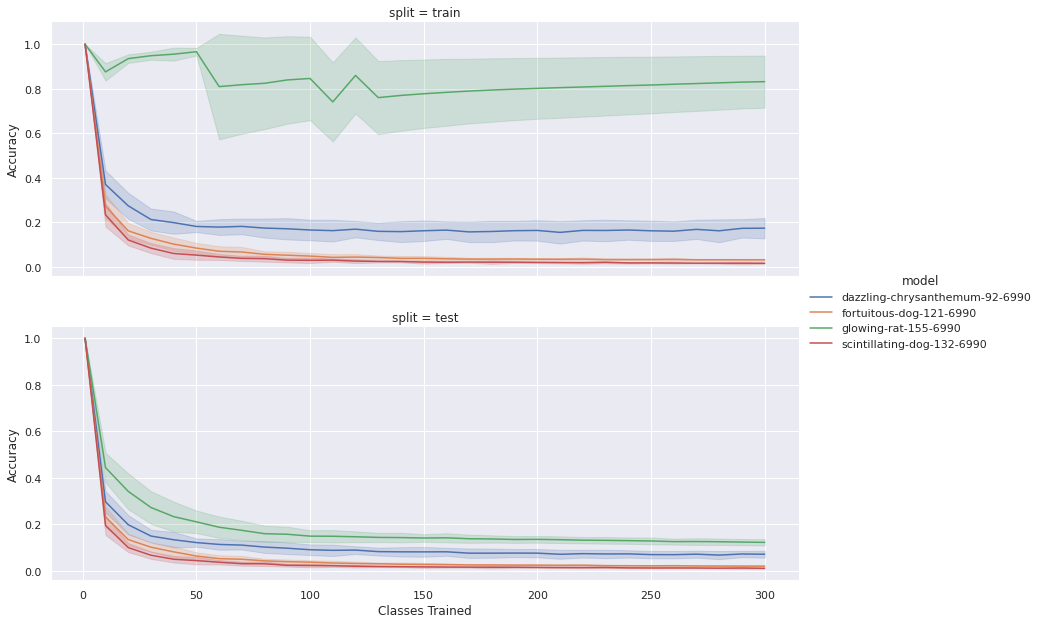

In [258]:
# Plot results
fg = plot_traj_per_lr(olft_best_lrs)

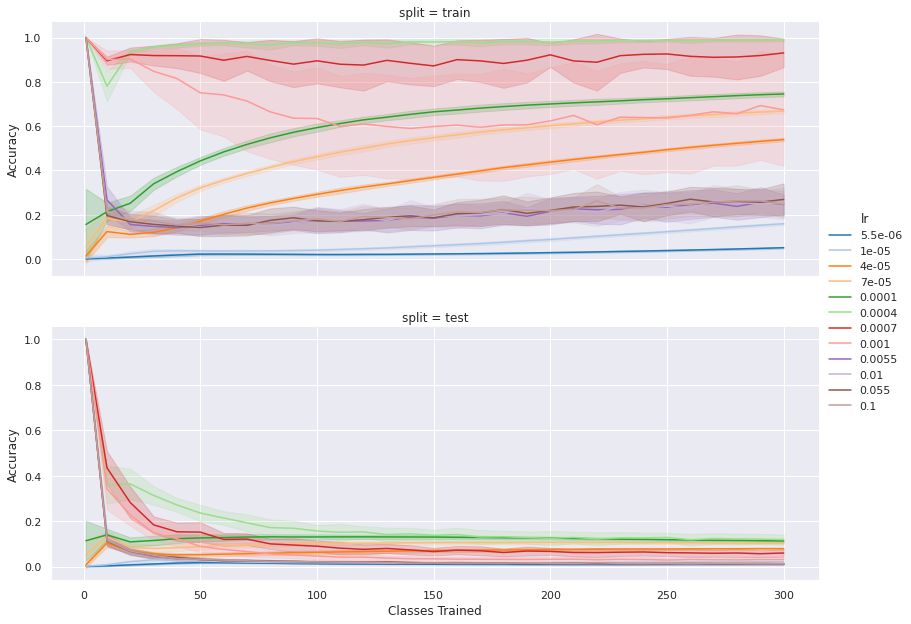

In [260]:
rows = olft_overall_accuracy.index.get_level_values("model") == "glowing-rat-155-6990"
desired_rows = olft_overall_accuracy.loc[rows]
fg = plot_traj_per_lr(desired_rows, palette="tab20")

### Best Models Overall

Rate each model based on final test performance with its best LR. Also show training details for each model.

In [263]:
# Print final accuracy per model, when fine-tuned on this number of examples.
olft_perf_per_model = get_final_perf_per_model(olft_best_lrs, num_train_examples, print_result=True)

Final accuracy on 300 classes:
dazzling-chrysanthemum-92-6990 |  7.1% (std: 1.5%)
       fortuitous-dog-121-6990 |  2.0% (std: 0.2%)
          glowing-rat-155-6990 | 12.2% (std: 1.4%)
    scintillating-dog-132-6990 |  1.1% (std: 0.2%)


In [264]:
get_model_descriptions(olft_best_lrs)

,train_dataset,model_name,train_method,lobotomize,train_lr,inner_lr,outer_lr,seed
model,,,,,,,,
dazzling-chrysanthemum-92-6990,omniimage100,resnet18,iid,False,0.0030,0.0,0.0,29384
fortuitous-dog-121-6990,omniimage100,resnet18,iid,False,0.0010,0.0,0.0,29384
glowing-rat-155-6990,omniimage100,sanml,iid,False,0.0030,0.0,0.0,29384
scintillating-dog-132-6990,omniimage100,resnet18,iid,False,0.0003,0.0,0.0,29384


In [265]:
# Get the top N models according to final test performance.
num_top_models = 5
sorted_models = sorted(olft_perf_per_model, key=lambda k: olft_perf_per_model[k]["mean"].item(), reverse=True)
top_models = sorted_models[:num_top_models]
print(f"Top models: {top_models}")
top_model_df = filter_by_model(olft_best_lrs, top_models)

Top models: ['glowing-rat-155-6990', 'dazzling-chrysanthemum-92-6990', 'fortuitous-dog-121-6990', 'scintillating-dog-132-6990']


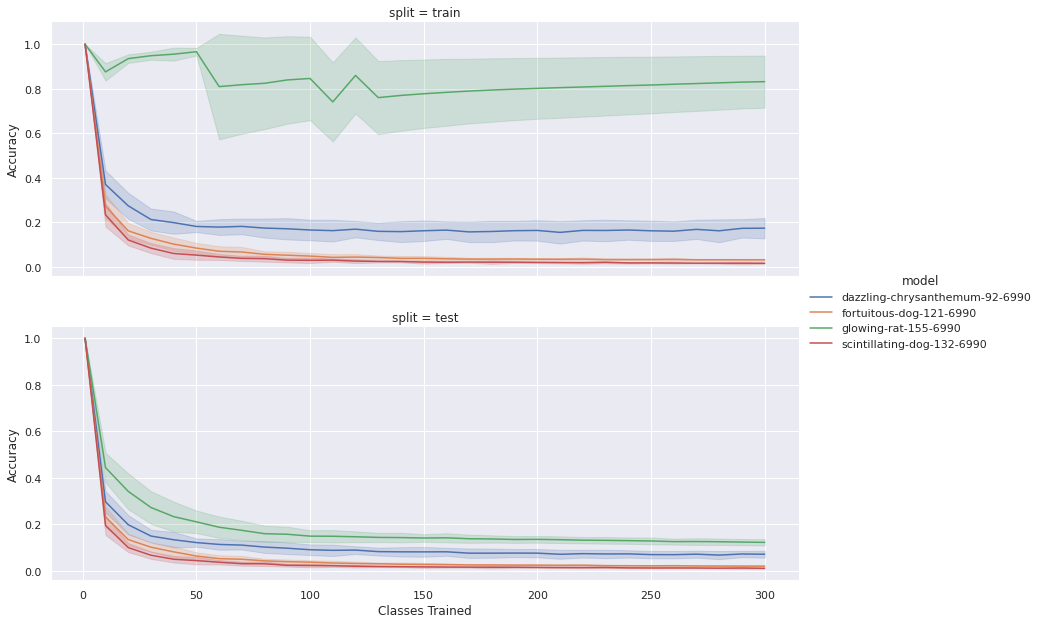

In [266]:
# Re-do the plot with just the top models.
_ = plot_traj_per_lr(top_model_df)

### Best Models Per Category

In [269]:
group_cols = ["model_name", "train_method", "lobotomize"]
best_olft_models = get_top_model_per_group(olft_best_lrs, olft_perf_per_model, group_cols)
best_olft_models

,,,,mean,std
model_name,train_method,lobotomize,model,,
resnet18,iid,False,dazzling-chrysanthemum-92-6990,0.071302,0.014866
sanml,iid,False,glowing-rat-155-6990,0.122230,0.013665


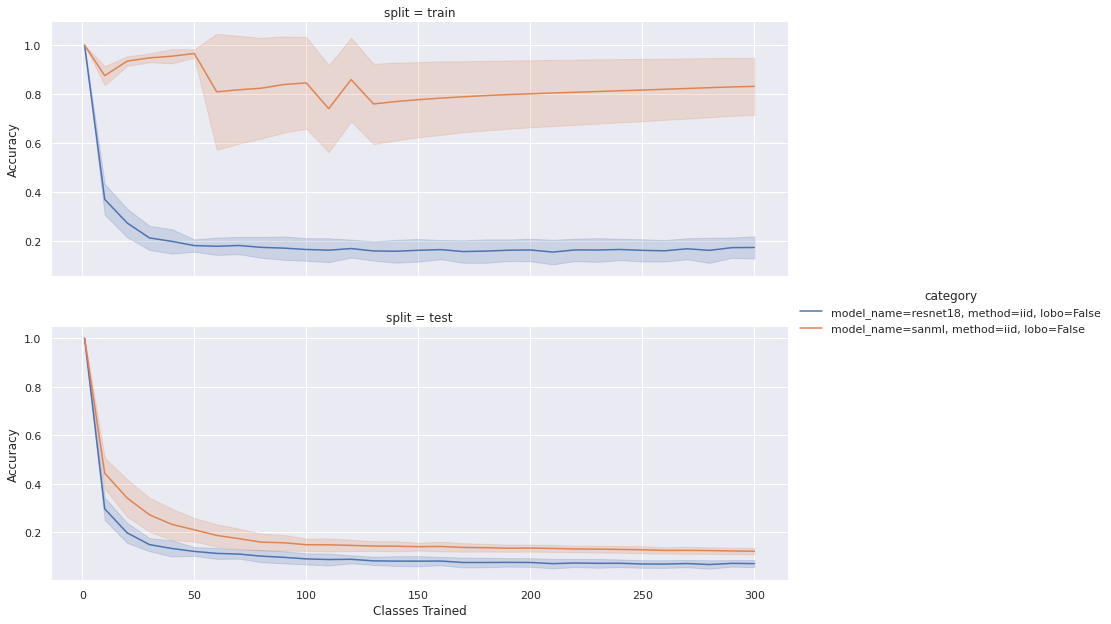

In [270]:
# Now plot them.
best_olft_df = filter_to_match_models(olft_best_lrs, best_olft_models).copy()
add_category_column(best_olft_df, group_cols)
_ = plot_traj_per_lr(best_olft_df, hue="category")

# i.i.d. Fine-Tuning Evaluation

## Unfrozen

### Best Models Per Category

In [289]:
iid_df = all_frames["iid-unfrozen-lg"].drop(["train_top5_acc", "test_top5_acc"], axis="columns")
iid_df = filter_by_value(iid_df, "train_dataset", "omniimage100")
iid_overall_accuracy = combine_train_test_columns(iid_df)
iid_overall_accuracy = rename_like_models(iid_overall_accuracy)

In [290]:
# Filter the data to the desired number of training examples.
# num_train_examples = 500
# rows = iid_overall_accuracy.index.get_level_values("train_examples") == num_train_examples
# desired_rows = iid_overall_accuracy.loc[rows]
desired_rows = iid_overall_accuracy
iid_best_lrs = select_best_lr_per_group(desired_rows)

In [291]:
get_model_descriptions(iid_best_lrs)

,train_dataset,model_name,train_method,lobotomize,train_lr,inner_lr,outer_lr,seed
model,,,,,,,,
dazzling-chrysanthemum-92-6990,omniimage100,resnet18,iid,False,0.0030,0.0,0.0,29384
fortuitous-dog-121-6990,omniimage100,resnet18,iid,False,0.0010,0.0,0.0,29384
glowing-rat-155-6990,omniimage100,sanml,iid,False,0.0030,0.0,0.0,29384
scintillating-dog-132-6990,omniimage100,resnet18,iid,False,0.0003,0.0,0.0,29384


In [292]:
# Print final accuracy per model, when fine-tuned on this number of examples.
iid_perf_per_model = get_final_perf_per_model(iid_best_lrs, num_train_examples, print_result=True)

Final accuracy on 300 classes:
dazzling-chrysanthemum-92-6990 | 26.0% (std: 0.8%)
       fortuitous-dog-121-6990 | 16.9% (std: 1.6%)
          glowing-rat-155-6990 | 28.2% (std: 0.8%)
    scintillating-dog-132-6990 |  6.1% (std: 0.8%)


In [293]:
group_cols = ["model_name", "train_method", "lobotomize"]
best_iid_models = get_top_model_per_group(iid_best_lrs, iid_perf_per_model, group_cols)
best_iid_models

,,,,mean,std
model_name,train_method,lobotomize,model,,
resnet18,iid,False,dazzling-chrysanthemum-92-6990,0.259667,0.008230
sanml,iid,False,glowing-rat-155-6990,0.281567,0.008221


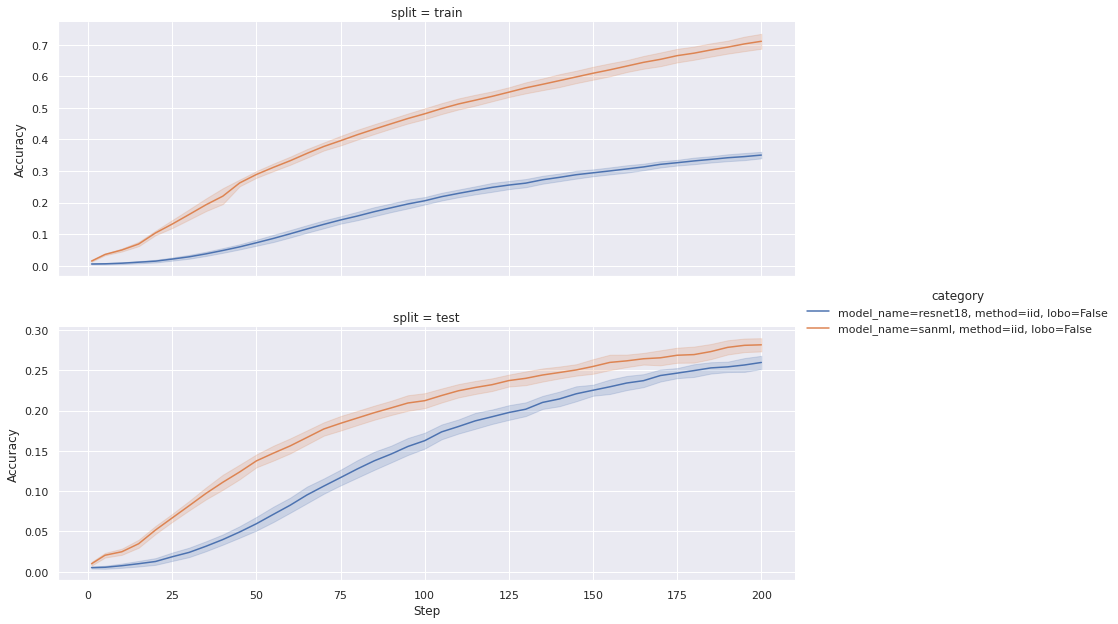

In [294]:
# Now plot them. Copy to avoid a SettingWithCopy warning.
best_iid_df = filter_to_match_models(iid_best_lrs, best_iid_models).copy()
add_category_column(best_iid_df, group_cols)
_ = plot_traj_per_lr(best_iid_df, hue="category")

# No SGD ("Zero-Shot") Results

In [301]:
zero_df = all_frames["no-sgd-lg"].drop(["train_top5_acc", "test_top5_acc"], axis="columns")
zero_df = filter_by_value(zero_df, "train_dataset", "omniimage100")
z_overall_accuracy = combine_train_test_columns(zero_df)
z_overall_accuracy = rename_like_models(z_overall_accuracy)
z_overall_accuracy

accuracy
model                      train_dataset model_name train_method lobotomize train_lr inner_lr outer_lr eval_dataset train_examples test_examples eval_method reinit_method reinit_params     classes trial seed  split          
scintillating-dog-132-6990 omniimage100  resnet18   iid          False      0.0003   0.0      0.0      omniimage100 85             15            zero_shot   lstsq         classifier.linear 300     0     29384 train  0.423569
                                                                                                                                                                                                     1     29384 train  0.423804
                                                                                                                                                                                                     2     29384 train  0.420745
                                                                                                                                                                                                     3     29384 train  0.424314
                                                                                                                                                                                                     4     29384 train  0.420549
...                                                                                                                                                                                                                          ...
glowing-rat-155-6990       omniimage100  sanml      iid          False      0.0030   0.0      0.0      omniimage100 85             15            zero_shot   lstsq         classifier.linear 300     5     49289 test   0.205111
                                                                                                                                                                                                     6     49289 test   0.204222
                                                                                                                                                                                                     7     49289 test   0.206222
                                                                                                                                                                                                     8     49289 test   0.193333
                                                                                                                                                                                                     9     49289 test   0.199556

[220 rows x 1 columns]

In [302]:
# Print final accuracy per model, when fine-tuned on this number of examples.
z_perf_per_model = get_final_perf_per_model(z_overall_accuracy, num_train_examples, print_result=True)

Final accuracy on 300 classes:
    scintillating-dog-132-6990 | 25.4% (std: 0.6%)
       fortuitous-dog-121-6990 | 30.2% (std: 0.8%)
dazzling-chrysanthemum-92-6990 | 27.5% (std: 1.3%)
          glowing-rat-155-6990 | 20.0% (std: 0.5%)


In [307]:
_ = get_final_perf_per_model(z_overall_accuracy, num_train_examples, split="train", print_result=True)

Final accuracy on 300 classes:
    scintillating-dog-132-6990 | 42.3% (std: 0.2%)
       fortuitous-dog-121-6990 | 45.6% (std: 0.5%)
dazzling-chrysanthemum-92-6990 | 44.5% (std: 0.8%)
          glowing-rat-155-6990 | 99.9% (std: 0.0%)


In [ ]:
df = all_frames["olft"]#.drop(["train_top5_acc", "test_top5_acc"], axis="columns")
df = filter_by_value(df, "train_dataset", "omniimage20")
df = combine_train_test_columns(df)
df = rename_like_models(df)
df = select_best_lr_per_group(df)
_ = get_final_perf_per_model(df, num_train_examples, split="train", print_result=True)
perf_per_model = get_final_perf_per_model(df, num_train_examples, split="test", print_result=True)
get_top_model_per_group(df, perf_per_model, group_cols)

In [324]:
get_model_descriptions(df)

,train_dataset,model_name,train_method,lobotomize,train_lr,inner_lr,outer_lr,seed
model,,,,,,,,
auspicious-dumpling-27-1260,omniimage20,resnet18,iid,False,0.0003,0.0,0.0,29384
beaming-rabbit-47-1260,omniimage20,sanml,iid,False,0.0030,0.0,0.0,29384
glittering-pig-24-1260,omniimage20,resnet18,iid,False,0.0010,0.0,0.0,29384
glittering-snake-21-1260,omniimage20,resnet18,iid,False,0.0030,0.0,0.0,29384
golden-festival-79-1260,omniimage20,sanml,iid,False,0.0003,0.0,0.0,29384
red-orchid-49-1260,omniimage20,sanml,iid,False,0.0010,0.0,0.0,29384


# Sensitivity to Learning Rate (Deprecated)

This section has not yet been updated to conform to the new dataframe format.

CPU times: user 2.2 s, sys: 59.4 ms, total: 2.26 s
Wall time: 3.35 s


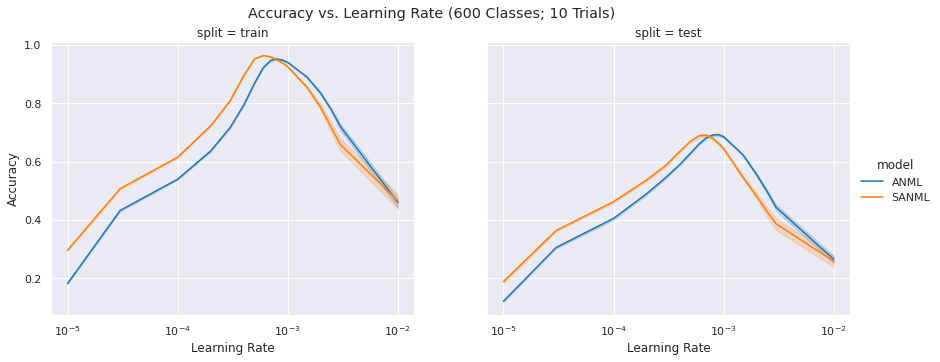

In [52]:
%%time

import warnings
from numbers import Number

# We want to plot the result of learning this number of classes across different choices of learning rate.
def plot_perf_vs_learning_rate(df, num_classes_learned, lr_range=None):

    # Filter down to just the slice that has learned this many classes.
    if isinstance(num_classes_learned, Number):
        # Convert to list of numbers first.
        num_classes_learned = [num_classes_learned]
    classes_trained = df.index.get_level_values("classes_trained")
    df = df.loc[classes_trained.map(lambda x: x in num_classes_learned), :]
    
    # Filter to only the desired learning rates.
    if lr_range:
        assert len(lr_range) == 2
        lrs = df.index.get_level_values("lr")
        rows = (lrs >= lr_range[0]) & (lrs <= lr_range[1])
        df = df.loc[rows, :]        
    
    # We want to make sure we are not accidentally aggregating across runs with different configs.
    ensure_unique(df, ["eval_dataset", "num_test_examples"])
    # Only add more levels of nesting if needed.
    hue = None
    if df.index.get_level_values("model").nunique() > 1:
        hue = "model"
    style = None
    nte = df.index.get_level_values("num_train_examples")
    ct = df.index.get_level_values("classes_trained")
    if nte.nunique() > 1 and ct.nunique() > 1:
        # We can't have both of these at once.
        raise RuntimeError("Cannot show multiple values of both 'num_train_examples' and 'classes_trained'.")
    elif ct.nunique() > 1:
        style = "classes_trained"
    elif nte.nunique() > 1:
        style = "num_train_examples"

    # Temporarily suppress this annoying and unnecessary warning coming from Seaborn.
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message=".*not compatible with tight_layout.*")
        fg = sns.relplot(
            data=df,
            x="lr",
            y="accuracy",
            col="split",
            hue=hue,
            style=style,
            palette="tab10",
            kind="line",
            #ci="sd",  # Remove this to plot 95% CI instead. It will take a long time.
            aspect=1.3,
            facet_kws=dict(gridspec_kws=dict(top=0.88))
        )
    # Adjust labels.
    ntrials = df.index.get_level_values("trial").nunique()
    fg.set(xscale="log")
    cls_text = ""
    if len(num_classes_learned) == 1:
        cls_text = f"{num_classes_learned[0]} Classes; "
    fg.figure.suptitle(f"Accuracy vs. Learning Rate ({cls_text}{ntrials} Trials)")
    fg.set_axis_labels("Learning Rate", "Accuracy")


# Determine which point(s) on the learning trajectories to plot.
num_classes = [600]
# Now do the plotting.
plot_perf_vs_learning_rate(olft_overall_accuracy, num_classes)#, lr_range=(float("-inf"), 0.03))

# Scratch Space

In [226]:
import itertools

failed_trainings = []
for name in train_configs:
    train_cfg = train_configs[name]
    pdir = train_config_files[name].parent
    # Check to see if any evaluation is present.
    evals = list(pdir.glob("eval-*"))
    evals_with_data = list(itertools.chain(*(e.glob("*.pkl") for e in evals)))
    if not evals_with_data:
        print(f"{name:30} {train_cfg['dataset']:13} {train_cfg.get('imgs_per_class', ''):4} {train_cfg['model_name']:13}")
        failed_trainings.append(pdir)

print(f"\nTotal of {len(failed_trainings)} models missing.")

abundant-pig-8                 omni               resnet18     
enchanting-rabbit-6            omni               resnet18     
filigreed-firecracker-211      miniimagenet       resnet18     
flashing-paper-200             miniimagenet       resnet18     
glistening-horse-4             omni               resnet18     
glistening-wish-233            miniimagenet       resnet18     
glowing-paper-1                omni               resnet18     
legendary-wish-3               omni               resnet18     
lucky-laughter-216             miniimagenet       resnet18     
lucky-monkey-10                omni               resnet18     
luminous-cake-207              miniimagenet       resnet18     
scintillating-envelope-9       omni               resnet18     
vibrant-cake-2                 omni               resnet18     
virtuous-springroll-5          omni               resnet18     
vivid-dog-7                    omni               resnet18     

Total of 15 models missing.
